In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import keras
keras.__version__

from keras import models
from keras import layers
from keras import regularizers
from keras import optimizers
from keras.models import load_model
import h5py


from keras.utils import to_categorical

In [ ]:
import numpy as np
import csv
import random
import matplotlib.pyplot as plt
from google.colab import files

plt.rcParams['mathtext.fontset'] = 'stix' 
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18

Tc_sqnn=2/np.log(1+np.sqrt(2)) #NN square lattice
Tc_sqnnn=2.1 #NNN square lattice, J2=1
L=30

In [ ]:
dict_graphs_nn={}
Tnn=[1.92,1.59,1.29,0.9,0.81,0.69,0.63,0.6,0.48] #T's order: .1, ..., .4, .42, .44, .46, .48, .5 (pico del cv del MC)
dict_graphs_nnn={}
Tnnn=[0.48,0.63,0.72,0.84,0.9,0.96,1.29,1.62,1.83] #T's order: .5, .52, .54, .56, .58, .6, ..., .9 (pico del cv del MC)
markers=['o','^','x','s','h','p','D','*','v','P']
colors=['green','darkblue','orange','gold','pink','c','cyan','purple', 'darkred','mediumvioletred']

#From data with J2=0 to non-zero-J2 data

We start by training the AF square lattice without NNN couplings

In [ ]:
##J2=0

data_path='drive/My Drive/Tesina und Paper/Data/SquareJ1J2/0.txt'
data=[]
with open(data_path, newline='\n') as csvfile:
  csv_reader = csv.reader(csvfile, delimiter=' ')
  for linea in csv_reader:
    data.append(linea)

for x in data:
  x.remove('')

random.shuffle(data) # shuffle all data


In [ ]:
a=0.1 #data from T such that |Tc-T|<a will be removed from our train data set

test_labels_a=[]
test_temperatures_a=[]
train_labels_a=[]
train_temperatures_a=[]
train_data_a=[]
test_data_a=[]
print("removed data: from ", Tc_sqnn-a," to ",Tc_sqnn+a)
for element in data:
  proba=random.random()
  if ((float(element[1])>=(Tc_sqnn-a) and float(element[1])<=(Tc_sqnn+a)) or (proba<0.15)):
    TT=element.pop(0)  # remove the first element, the temperature
    test_temperatures_a.append(TT) # add to temperature list
    test_data_a.append(element)
    if float(TT)> Tc_sqnn:
      test_labels_a.append(1)
    else:
      test_labels_a.append(0)
  else:
    TT=element.pop(0)  # remove the first element, the temperature
    train_temperatures_a.append(TT) # add to temperature list
    train_data_a.append(element)
    if float(TT)> Tc_sqnn:
      train_labels_a.append(1)
    else:
      train_labels_a.append(0)
    

#numpy arrays of strings, and string to integers
train_data_a=np.array(train_data_a)
scaled_tr=len(train_data_a)
train_data_a=train_data_a.reshape(scaled_tr,L,L,1)
train_data_a = train_data_a.astype(np.float)
train_data_a=(train_data_a+1.)/2 # data normalization 

test_data_a=np.array(test_data_a)
scaled_te=len(test_data_a)
test_data_a=test_data_a.reshape(scaled_te,L,L,1)
test_data_a = test_data_a.astype(np.float)
test_data_a=(test_data_a+1.)/2 # data normalization

train_labels_a=np.array(train_labels_a)
train_labels_a = train_labels_a.astype(np.int)

test_labels_a=np.array(test_labels_a)
test_labels_a = test_labels_a.astype(np.int)

train_temperatures_a=np.array(train_temperatures_a)
train_temperatures_a=train_temperatures_a.astype(np.float)

test_temperatures_a=np.array(test_temperatures_a)
test_temperatures_a=test_temperatures_a.astype(np.float)


#to check everything went fine
print('length of train data: ', len(train_data_a))

print('length of test data: ', len(test_data_a))

train_labels_a = to_categorical(train_labels_a)
test_labels_a = to_categorical(test_labels_a)

removed data: from  2.169185314213022  to  2.369185314213022
length of train data:  67968
length of test data:  12032


In [ ]:
damn=optimizers.Adam(lr=0.001,beta_1=0.9, beta_2=0.999, amsgrad=False)

model0 = models.Sequential()
model0.add(layers.Conv2D(10, (3, 3), activation='relu', input_shape=(L, L, 1)))
model0.add(layers.MaxPooling2D((2, 2)))
model0.add(layers.Flatten())
model0.add(layers.Dense(5, activation='relu'))
model0.add(layers.Dense(2, activation='softmax'))


epochs_val=6
Bsize=300


model0.compile(optimizer=damn,
loss='categorical_crossentropy',
metrics=['accuracy'])
history=model0.fit(train_data_a, train_labels_a, validation_split=0.1,
          shuffle=True, epochs=epochs_val, batch_size=Bsize)

history_dict = history.history
print('history_dictionary: ', history_dict.keys())

#-----------------------------

#modelname0='drive/My Drive/Tesina und Paper/model_sq2nd_belowJ2.h5'
#model0 = load_model(modelname0) #loads a previously saved model
test_predictions=model0.predict(test_data_a)

prob_T=[]
for j in range(len(test_temperatures_a)):
  prob_T.append([test_temperatures_a[j],test_predictions[j]])

prob_T=sorted(prob_T,key=lambda x: x[0])
len(prob_T)

j=0
epsilon=0.001
j_max=len(prob_T)

while(j+1 < j_max-1):
  count=1
  while(j+1 < j_max and abs(prob_T[j][0]-prob_T[j+1][0]  )<epsilon):
    count=count+1
    x=prob_T.pop(j+1)
    prob_T[j][1]=prob_T[j][1]+x[1]
    j_max=len(prob_T)
  prob_T[j][1]=prob_T[j][1]/float(count)
  j=j+1
  j_max=len(prob_T)

print('number of temperatures: ',len(prob_T))

### plotting

T_lista=[]
p1_lista=[];p2_lista=[];check_list=[]

for j in range(len(prob_T)):
  T_lista.append(prob_T[j][0])
  p1_lista.append(prob_T[j][1][0])
  p2_lista.append(prob_T[j][1][1])


plt.plot(T_lista, p1_lista, color='darkred',marker='s')
plt.plot(T_lista, p2_lista, color='darkblue',marker='s')
plt.title('AF Square '+str(int(L))+'x'+str(int(L))+' lattice - a='+str(float(a)),size = 15)
plt.xlabel('T/J',size = 15)
plt.ylabel('Probabilities',size = 15)

plt.axvline(x=Tc_sqnn,color='black',linestyle='--')
plt.axvline(x=Tc_sqnn-a,color='gray',linestyle='--')
plt.axvline(x=Tc_sqnn+a,color='gray',linestyle='--')
plt.hlines(y=0.5,xmin=-0.1,xmax=4.1,color='black',linestyle='--')

plt.xlim(1.5,3)

plt.show()

In [ ]:
#if you like the results, you can save your model running this cell
dict_graphs_nn['p1_0']=p1_lista
dict_graphs_nn['p2_0']=p2_lista
modelpath='drive/My Drive/Tesina und Paper'
modelname0=modelpath+'/model_sq2nd_belowJ2.h5'

model0.save(modelname0)  # creates a HDF5 file 'my_model.h5'

##Predictions for data with non-zero J2

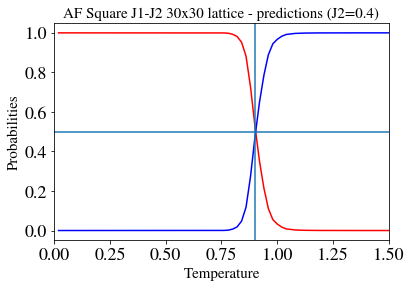

In [ ]:
J2=0.4

### load data
data_path2='drive/My Drive/Tesina und Paper/Data/SquareJ1J2/'+str(J2)+'.txt'

data2=[]
with open(data_path2, newline='\n') as csvfile2:
  csv_reader2 = csv.reader(csvfile2, delimiter=' ')
  for line in csv_reader2:
    data2.append(line)

for x2 in data2:
  x2.remove('')

random.shuffle(data2) # shuffle all data

labels2=[]
temperatures2=[]
for element2 in data2:
  TT2=element2.pop(0)  # remove the first element, the temperature
  temperatures2.append(TT2) # add to temperature list

#numpy arrays of strings, and string to integers
blabla=len(data2)
data2=np.array(data2)
data2=data2.reshape(blabla,30,30,1)
data2 = data2.astype(np.float)
data2=(data2+1.)/2 # normalization 

temperatures2=np.array(temperatures2)
temperatures2=temperatures2.astype(np.float)

###DATA PREDICTIONS
#modelname0='drive/My Drive/Tesina und Paper/model_sq2nd_belowJ2.h5'
#model0 = load_model(modelname0)
predictions2=model0.predict(data2)

prob_T=[]
for j in range(len(temperatures2)):
  prob_T.append([temperatures2[j],predictions2[j]])

prob_T=sorted(prob_T,key=lambda x: x[0])
len(prob_T)

j=0
epsilon=0.001
j_max=len(prob_T)

while(j+1 < j_max-1):
  count=1
  while(j+1 < j_max and abs(prob_T[j][0]-prob_T[j+1][0]  )<epsilon):
    count=count+1
    x=prob_T.pop(j+1)
    prob_T[j][1]=prob_T[j][1]+x[1]
    j_max=len(prob_T)
  prob_T[j][1]=prob_T[j][1]/float(count)
  j=j+1
  j_max=len(prob_T)

print('number of temperatures: ',len(prob_T))

###plotting

T_list=[]
p1_list=[];p2_list=[];check_list=[]

for j in range(len(prob_T)):
  T_list.append(prob_T[j][0])
  p1_list.append(prob_T[j][1][0])
  p2_list.append(prob_T[j][1][1])

plt.plot(T_list, p1_list, 'r')
plt.plot(T_list, p2_list, 'b')
plt.xlim(0,1.5)

plt.title('AF Square J1-J2 30x30 lattice - predictions (J2='+str(J2)+')',size = 15)
plt.xlabel('Temperature',size = 15)
plt.ylabel('Probabilities',size = 15)
plt.axhline(y=0.5)
plt.axvline(x=0.9) #T of the peak of specific heat
#Tnn=[1.92,1.59,1.29,0.9,0.81,0.69,0.63,0.6,0.48]
plt.show()

In [ ]:
#save results in this dictionary, we will use all of them in the next subsection
dict_graphs_nn['p1_.'+str(J2)]=p1_list
dict_graphs_nn['p2_.'+str(J2)]=p2_list

##All probability curves together in the same graph

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

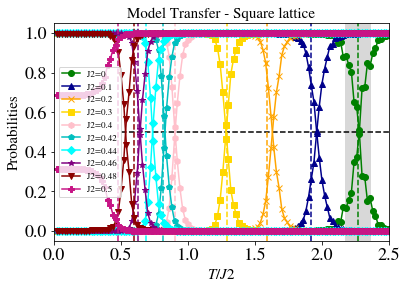

In [ ]:
#first of all, we plot the non-frustrated case
plt.plot(T_lista, dict_graphs_nn['p1_0'], color=colors[0], label='J2=0',marker=markers[0])
plt.plot(T_lista, dict_graphs_nn['p2_0'], color=colors[0],marker=markers[0])
plt.axvline(x=Tc_sqnn,color=colors[0],linestyle='--')

#then those with J2 from .1 to .5
contt=1
i=0.1
plt.plot(T_list, dict_graphs_nn['p1_.'+str(i)], color=colors[contt], label='J2='+str(i),marker=markers[contt])
plt.plot(T_list, dict_graphs_nn['p2_.'+str(i)], color=colors[contt],marker=markers[contt])
plt.axvline(x=Tnn[contt-1],color=colors[contt],linestyle='--')
contt+=1
i=0.2
plt.plot(T_list, dict_graphs_nn['p1_.'+str(i)], color=colors[contt], label='J2='+str(i),marker=markers[contt])
plt.plot(T_list, dict_graphs_nn['p2_.'+str(i)], color=colors[contt],marker=markers[contt])
plt.axvline(x=Tnn[contt-1],color=colors[contt],linestyle='--')
contt+=1
i=0.3
plt.plot(T_list, dict_graphs_nn['p1_.'+str(i)], color=colors[contt], label='J2='+str(i),marker=markers[contt])
plt.plot(T_list, dict_graphs_nn['p2_.'+str(i)], color=colors[contt],marker=markers[contt])
plt.axvline(x=Tnn[contt-1],color=colors[contt],linestyle='--')
contt+=1
i=0.4
plt.plot(T_list, dict_graphs_nn['p1_.0.4'], color=colors[contt], label='J2='+str(i),marker=markers[contt])
plt.plot(T_list, dict_graphs_nn['p2_.0.4'], color=colors[contt],marker=markers[contt])
plt.axvline(x=Tnn[contt-1],color=colors[contt],linestyle='--')
contt+=1
i=0.42
plt.plot(T_list, dict_graphs_nn['p1_.0.42'], color=colors[contt], label='J2='+str(i),marker=markers[contt])
plt.plot(T_list, dict_graphs_nn['p2_.0.42'], color=colors[contt],marker=markers[contt])
plt.axvline(x=Tnn[contt-1],color=colors[contt],linestyle='--')
contt+=1
i=0.44
plt.plot(T_list, dict_graphs_nn['p1_.0.44'], color=colors[contt], label='J2='+str(i),marker=markers[contt])
plt.plot(T_list, dict_graphs_nn['p2_.0.44'], color=colors[contt],marker=markers[contt])
plt.axvline(x=Tnn[contt-1],color=colors[contt],linestyle='--')
contt+=1
i=0.46
plt.plot(T_list, dict_graphs_nn['p1_.0.46'], color=colors[contt], label='J2='+str(i),marker=markers[contt])
plt.plot(T_list, dict_graphs_nn['p2_.0.46'], color=colors[contt],marker=markers[contt])
plt.axvline(x=Tnn[contt-1],color=colors[contt],linestyle='--')
contt+=1
i=0.48
plt.plot(T_list, dict_graphs_nn['p1_.0.48'], color=colors[contt], label='J2='+str(i),marker=markers[contt])
plt.plot(T_list, dict_graphs_nn['p2_.0.48'], color=colors[contt],marker=markers[contt])
plt.axvline(x=Tnn[contt-1],color=colors[contt],linestyle='--')
contt+=1
plt.plot(T_list, dict_graphs_nn['p1_.0.5'], color=colors[contt], label='J2=0.5',marker=markers[contt])
plt.plot(T_list, dict_graphs_nn['p2_.0.5'], color=colors[contt],marker=markers[contt])
plt.axvline(x=Tnn[contt-1],color=colors[contt],linestyle='--')


plt.title('Model Transfer - Square lattice',size = 15)
plt.xlabel(r'$T/J2$',size = 15)
plt.ylabel('Probabilities',size = 15)
plt.legend(loc='center left',prop={'size': 9})
g1=Tc_sqnn-a ; g2=Tc_sqnn+a
plt.axvspan(g1, g2, color='gray', alpha=0.3, lw=0) # shaded gray area
xmaxx=2.5
plt.hlines(y=0.5,xmin=0.5,xmax=xmaxx,color='black',linestyle='--')
plt.xlim(0,2.5)

plt.savefig('sq_J2below0.5.pdf',bbox_inches='tight')
files.download('sq_J2below0.5.pdf')
plt.show()

#From data with J2=1 to data with smaller J2 values

In [ ]:
##J2=1

data_path='drive/My Drive/Tesina und Paper/Data/SquareJ1J2/1.txt'
data=[]
with open(data_path, newline='\n') as csvfile:
  csv_reader = csv.reader(csvfile, delimiter=' ')
  for linea in csv_reader:
    data.append(linea)

for x in data:
  x.remove('')

random.shuffle(data) # shuffle all data


In [ ]:
a=0.1 #data from T such that |Tc-T|<a will be removed from our train data set

test_labels_a=[]
test_temperatures_a=[]
train_labels_a=[]
train_temperatures_a=[]
train_data_a=[]
test_data_a=[]
print("removed from ", Tc_sqnnn-a," to ",Tc_sqnnn+a)
for element in data:
  proba=random.random()
  if ((float(element[1])>=(Tc_sqnnn-a) and float(element[1])<=(Tc_sqnnn+a)) or (proba<0.15)):
    TT=element.pop(0)  # removes first element
    test_temperatures_a.append(TT) # adds it to temperature list
    test_data_a.append(element)
    if float(TT)> Tc_sqnnn:
      test_labels_a.append(1)
    else:
      test_labels_a.append(0)
  else:
    TT=element.pop(0)  # removes first element
    train_temperatures_a.append(TT) # adds it to temperature list
    train_data_a.append(element)
    if float(TT)> Tc_sqnnn:
      train_labels_a.append(1)
    else:
      train_labels_a.append(0)
    

#numpy arrays of strings, and string to integers
train_data_a=np.array(train_data_a)
rescaled_tr=len(train_data_a)
train_data_a=train_data_a.reshape(rescaled_tr,L,L,1)
train_data_a = train_data_a.astype(np.float)
train_data_a=(train_data_a+1.)/2 # normalization 

test_data_a=np.array(test_data_a)
rescaled_te=len(test_data_a)
test_data_a=test_data_a.reshape(scaled_te,L,L,1)
test_data_a = test_data_a.astype(np.float)
test_data_a=(test_data_a+1.)/2 # normalization

train_labels_a=np.array(train_labels_a)
train_labels_a = train_labels_a.astype(np.int)

test_labels_a=np.array(test_labels_a)
test_labels_a = test_labels_a.astype(np.int)

train_temperatures_a=np.array(train_temperatures_a)
train_temperatures_a=train_temperatures_a.astype(np.float)

test_temperatures_a=np.array(test_temperatures_a)
test_temperatures_a=test_temperatures_a.astype(np.float)


#c
print('length of train data: ', len(train_data_a))

print('length of test data: ', len(test_data_a))

train_labels_a = to_categorical(train_labels_a)
test_labels_a = to_categorical(test_labels_a)

entre  2.0  y  2.2
length of train data:  67925
length of test data:  12075


Train on 61132 samples, validate on 6793 samples
Epoch 1/6
61132/61132 [==============================] - 15s 246us/step - loss: 0.0893 - accuracy: 0.9754 - val_loss: 0.0213 - val_accuracy: 0.9909
Epoch 2/6
61132/61132 [==============================] - 15s 246us/step - loss: 0.0206 - accuracy: 0.9920 - val_loss: 0.0204 - val_accuracy: 0.9912
Epoch 3/6
61132/61132 [==============================] - 15s 244us/step - loss: 0.0199 - accuracy: 0.9922 - val_loss: 0.0209 - val_accuracy: 0.9913
Epoch 4/6
61132/61132 [==============================] - 15s 243us/step - loss: 0.0192 - accuracy: 0.9922 - val_loss: 0.0216 - val_accuracy: 0.9912
Epoch 5/6
61132/61132 [==============================] - 16s 265us/step - loss: 0.0192 - accuracy: 0.9922 - val_loss: 0.0215 - val_accuracy: 0.9912
Epoch 6/6
61132/61132 [==============================] - 15s 246us/step - loss: 0.0189 - accuracy: 0.9925 - val_loss: 0.0204 - val_accuracy: 0.9912
history_dictionary:  dict_keys(['val_loss', 'val_accuracy', 'lo

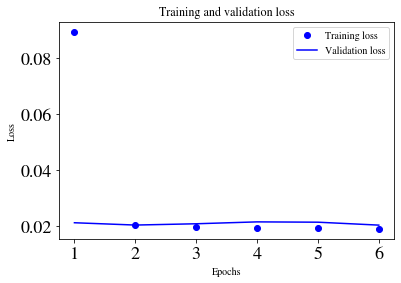

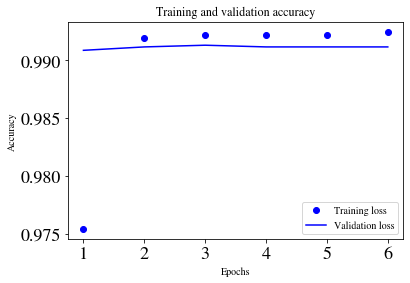

In [ ]:
damn=optimizers.Adam(lr=0.001,beta_1=0.9, beta_2=0.999, amsgrad=False)

model = models.Sequential()
model.add(layers.Conv2D(10, (3, 3), activation='relu', input_shape=(L, L, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))


epochs_val=6
Bsize=400

model.compile(optimizer=damn,
loss='categorical_crossentropy',
metrics=['accuracy'])
history=model.fit(train_data_a, train_labels_a, validation_split=0.1,
          shuffle=True, epochs=epochs_val, batch_size=Bsize)

history_dict = history.history
print('history_dictionary: ', history_dict.keys())
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, epochs_val + 1)
#“bo” is for“blue dot.”
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
#“b” is for “solid blue line.”
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.clf()

#plotting accuracies
acc_values=history_dict['accuracy']
val_acc_values=history_dict['val_accuracy']
plt.plot(epochs, acc_values, 'bo', label='Training loss')
plt.plot(epochs, val_acc_values, 'b', label='Validation loss')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

number of temperatures:  200


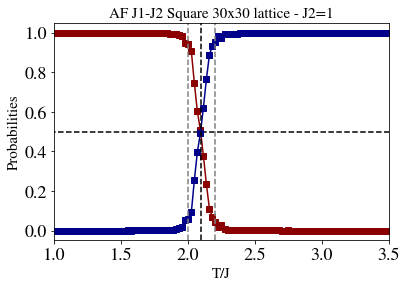

In [ ]:
#modelname='drive/My Drive/Teziz/corridas bonitas pal paper/model_sq2nd_aboveJ2.h5' #carga
#model = load_model(modelname) #carga del modelo guardado
test_predictions=model.predict(test_data_a)

prob_T=[]
for j in range(len(test_temperatures_a)):
  prob_T.append([test_temperatures_a[j],test_predictions[j]])
prob_T=sorted(prob_T,key=lambda x: x[0])
len(prob_T)

j=0
epsilon=0.001
j_max=len(prob_T)

while(j+1 < j_max-1):
  count=1
  while(j+1 < j_max and abs(prob_T[j][0]-prob_T[j+1][0]  )<epsilon):
    count=count+1
    x=prob_T.pop(j+1)
    prob_T[j][1]=prob_T[j][1]+x[1]
    j_max=len(prob_T)
  prob_T[j][1]=prob_T[j][1]/float(count)
  j=j+1
  j_max=len(prob_T)

print('number of temperatures: ',len(prob_T))

### plotting


p1_lista1=[];p2_lista1=[]

for j in range(len(prob_T)):
  #T_lista1.append(prob_T[j][0])
  p1_lista1.append(prob_T[j][1][0])
  p2_lista1.append(prob_T[j][1][1])

plt.plot(T_lista1, p1_lista1, color='darkred',marker='s')
plt.plot(T_lista1, p2_lista1, color='darkblue',marker='s')
plt.title('AF J1-J2 Square '+str(int(L))+'x'+str(int(L))+' lattice - J2=1',size = 15)
plt.xlabel('T/J',size = 15)
plt.ylabel('Probabilities',size = 15)
plt.axvline(x=Tc_sqnnn,color='black',linestyle='--')
plt.axvline(x=Tc_sqnnn-a,color='gray',linestyle='--')
plt.axvline(x=Tc_sqnnn+a,color='gray',linestyle='--')
plt.hlines(y=0.5,xmin=-0.1,xmax=4.1,color='black',linestyle='--')
plt.xlim(1,3.5)

plt.show()

In [ ]:
#SI ME GUSTAN los resultados del test me los guardo para graficar el coso completo dps:
dict_graphs_nnn['p1_1']=p1_lista1
dict_graphs_nnn['p2_1']=p2_lista1

In [ ]:
modelpath='drive/My Drive/Tesina und Paper/'
modelname=modelpath+'/model_sq2nd_aboveJ2.h5'

model.save(modelname)  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

##Predictions for data with J2 less than unity

number of temperatures:  200


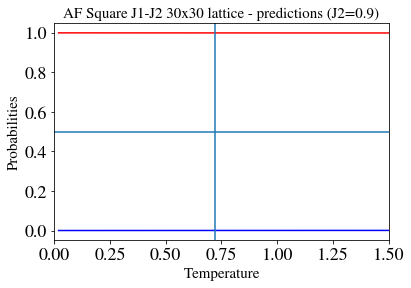

In [ ]:
J2=0.9

### load data
data_path4='drive/My Drive/Tesina und Paper/Data/SquareJ1J2/'+str(J2)+'.txt'
data4=[]
with open(data_path4, newline='\n') as csvfile1:
  csv_reader1 = csv.reader(csvfile1, delimiter=' ')
  for line in csv_reader1:
    data4.append(line)

for x3 in data4:
  x3.remove('')

random.shuffle(data4) # shuffle all data

labels4=[]
temperatures4=[]
for element in data4:
  TT4=element.pop(0)  # remove the first element
  temperatures4.append(TT4) # add to temperature list

#numpy arrays of strings, and string to integers
blabla=len(data4)
data4=np.array(data4)
data4=data4.reshape(blabla,30,30,1)
data4 = data4.astype(np.float)
data4=(data4+1.)/2 # normalizacion 
#data = data.astype(np.int)

#labels2=np.array(labels2)
#labels2 = labels2.astype(np.int)

temperatures4=np.array(temperatures4)
temperatures4=temperatures4.astype(np.float)

###DATA PREDICTIONS
#modelname='drive/My Drive/Tesina und Paper/model_sq2nd_aboveJ2.h5'
#model = load_model(modelname)
predictions4=model.predict(data4)

prob_T=[]
for j in range(len(temperatures4)):
  prob_T.append([temperatures4[j],predictions4[j]])
prob_T=sorted(prob_T,key=lambda x: x[0])
len(prob_T)

j=0
epsilon=0.001
j_max=len(prob_T)

while(j+1 < j_max-1):
  count=1
  while(j+1 < j_max and abs(prob_T[j][0]-prob_T[j+1][0]  )<epsilon):
    count=count+1
    x=prob_T.pop(j+1)
    prob_T[j][1]=prob_T[j][1]+x[1]
    j_max=len(prob_T)
  prob_T[j][1]=prob_T[j][1]/float(count)
  j=j+1
  j_max=len(prob_T)

print('number of temperatures: ',len(prob_T))

###plotting

T_list=[]
p1_list=[];p2_list=[];check_list=[]

for j in range(len(prob_T)):
  T_list.append(prob_T[j][0])
  p1_list.append(prob_T[j][1][0])
  p2_list.append(prob_T[j][1][1])
  check_list.append(prob_T[j][1][1] +prob_T[j][1][0] )




plt.plot(T_list, p1_list, 'r')
plt.plot(T_list, p2_list, 'b')
plt.xlim(0,1.5)

plt.title('AF Square J1-J2 30x30 lattice - predictions (J2='+str(J2)+')',size = 15)
plt.xlabel('Temperature',size = 15)
plt.ylabel('Probabilities',size = 15)
#plt.legend()
plt.axhline(y=0.5)
#Tnnn=[0.48,0.63,0.72,0.84,0.9,0.96,1.29,1.62,1.83]
plt.axvline(x=0.72)
plt.show()

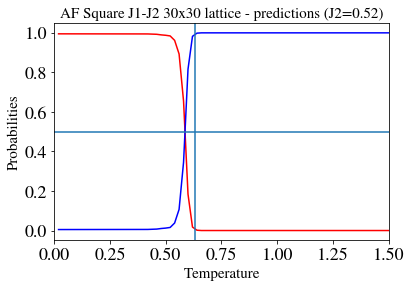

In [ ]:
J2=0.52

### load data
data_path4='drive/My Drive/Tesina und Paper/Data/SquareJ1J2/'+str(J2)+'.txt'
data4=[]
with open(data_path4, newline='\n') as csvfile1:
  csv_reader1 = csv.reader(csvfile1, delimiter=' ')
  for line in csv_reader1:
    data4.append(line)

for x3 in data4:
  x3.remove('')

random.shuffle(data4) # shuffle all data

labels4=[]
temperatures4=[]
for element in data4:
  TT4=element.pop(0)  # remove the first element
  temperatures4.append(TT4) # add to temperature list

#numpy arrays of strings, and string to integers
blabla=len(data4)
data4=np.array(data4)
data4=data4.reshape(blabla,30,30,1)
data4 = data4.astype(np.float)
data4=(data4+1.)/2 # normalization 


temperatures4=np.array(temperatures4)
temperatures4=temperatures4.astype(np.float)

###DATA PREDICTIONS
#modelname='drive/My Drive/Tesina und Paper/model_sq2nd_aboveJ2.h5'
#model = load_model(modelname)
predictions4=model.predict(data4)

prob_T=[]
for j in range(len(temperatures4)):
  prob_T.append([temperatures4[j],predictions4[j]])
prob_T=sorted(prob_T,key=lambda x: x[0])
len(prob_T)

j=0
epsilon=0.001
j_max=len(prob_T)

while(j+1 < j_max-1):
  count=1
  while(j+1 < j_max and abs(prob_T[j][0]-prob_T[j+1][0]  )<epsilon):
    count=count+1
    x=prob_T.pop(j+1)
    prob_T[j][1]=prob_T[j][1]+x[1]
    j_max=len(prob_T)
  prob_T[j][1]=prob_T[j][1]/float(count)
  j=j+1
  j_max=len(prob_T)

print('number of temperatures: ',len(prob_T))

###plotting

T_list=[]
p1_list=[];p2_list=[];check_list=[]

for j in range(len(prob_T)):
  T_list.append(prob_T[j][0])
  p1_list.append(prob_T[j][1][0])
  p2_list.append(prob_T[j][1][1])
  check_list.append(prob_T[j][1][1] +prob_T[j][1][0] )

plt.plot(T_list, p1_list, 'r')#, label='')
plt.plot(T_list, p2_list, 'b')#, label='')
plt.xlim(0,1.5)

plt.title('AF Square J1-J2 30x30 lattice - predictions (J2='+str(J2)+')',size = 15)
plt.xlabel('Temperature',size = 15)
plt.ylabel('Probabilities',size = 15)
#plt.legend()
plt.axhline(y=0.5)
#Tnnn=[0.48,0.63,0.72,0.84,0.9,0.96,1.29,1.62,1.83]
plt.axvline(x=0.63)
plt.show()

In [ ]:
#save probability curves to plot them later
dict_graphs_nnn['p1_.'+str(J2)]=p1_list
dict_graphs_nnn['p2_.'+str(J2)]=p2_list

## All probability curves together

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

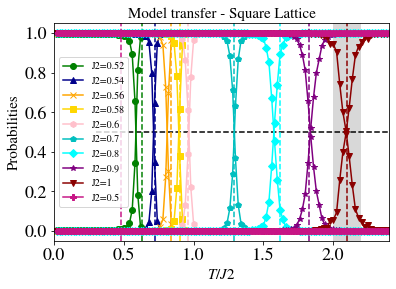

In [ ]:
#first, we plot the J2 values above .5
contt=0
i=0.52
plt.plot(T_list, dict_graphs_nnn['p1_.'+str(i)], color=colors[contt], label='J2='+str(i),marker=markers[contt])
plt.plot(T_list, dict_graphs_nnn['p2_.'+str(i)], color=colors[contt],marker=markers[contt])
plt.axvline(x=Tnnn[contt+1],color=colors[contt],linestyle='--')
contt+=1
i=0.54
plt.plot(T_list, dict_graphs_nnn['p1_.'+str(i)], color=colors[contt], label='J2='+str(i),marker=markers[contt])
plt.plot(T_list, dict_graphs_nnn['p2_.'+str(i)], color=colors[contt],marker=markers[contt])
plt.axvline(x=Tnnn[contt+1],color=colors[contt],linestyle='--')
contt+=1
i=0.56
plt.plot(T_list, dict_graphs_nnn['p1_.'+str(i)], color=colors[contt], label='J2='+str(i),marker=markers[contt])
plt.plot(T_list, dict_graphs_nnn['p2_.'+str(i)], color=colors[contt],marker=markers[contt])
plt.axvline(x=Tnnn[contt+1],color=colors[contt],linestyle='--')
contt+=1
i=0.58
plt.plot(T_list, dict_graphs_nnn['p1_.0.58'], color=colors[contt], label='J2='+str(i),marker=markers[contt])
plt.plot(T_list, dict_graphs_nnn['p2_.0.58'], color=colors[contt],marker=markers[contt])
plt.axvline(x=Tnnn[contt+1],color=colors[contt],linestyle='--')
contt+=1
i=0.6
plt.plot(T_list, dict_graphs_nnn['p1_.0.6'], color=colors[contt], label='J2='+str(i),marker=markers[contt])
plt.plot(T_list, dict_graphs_nnn['p2_.0.6'], color=colors[contt],marker=markers[contt])
plt.axvline(x=Tnnn[contt+1],color=colors[contt],linestyle='--')
contt+=1
i=0.7
plt.plot(T_list, dict_graphs_nnn['p1_.0.7'], color=colors[contt], label='J2='+str(float(i)),marker=markers[contt])
plt.plot(T_list, dict_graphs_nnn['p2_.0.7'], color=colors[contt],marker=markers[contt])
plt.axvline(x=Tnnn[contt+1],color=colors[contt],linestyle='--')
contt+=1
i=0.8
plt.plot(T_list, dict_graphs_nnn['p1_.0.8'], color=colors[contt], label='J2='+str(float(i)),marker=markers[contt])
plt.plot(T_list, dict_graphs_nnn['p2_.0.8'], color=colors[contt],marker=markers[contt])
plt.axvline(x=Tnnn[contt+1],color=colors[contt],linestyle='--')
contt+=1
i=0.9
plt.plot(T_list, dict_graphs_nnn['p1_.0.9'], color=colors[contt], label='J2='+str(float(i)),marker=markers[contt])
plt.plot(T_list, dict_graphs_nnn['p2_.0.9'], color=colors[contt],marker=markers[contt])
plt.axvline(x=Tnnn[contt+1],color=colors[contt],linestyle='--')
contt+=1
plt.plot(T_lista1, dict_graphs_nnn['p1_1'], color=colors[contt], label='J2=1',marker=markers[contt])
plt.plot(T_lista1, dict_graphs_nnn['p2_1'], color=colors[contt],marker=markers[contt])
plt.axvline(x=Tc_sqnnn,color=colors[contt],linestyle='--')

#we plot the 0.5 curves last
plt.plot(T_list, dict_graphs_nnn['p1_.0.5'], color=colors[9], label='J2=0.5',marker=markers[9])
plt.plot(T_list, dict_graphs_nnn['p2_.0.5'], color=colors[9],marker=markers[9])
plt.axvline(x=Tnnn[0],color=colors[9],linestyle='--')

plt.title('Model transfer - Square Lattice',size = 15)
plt.xlabel('$T/J2$',size = 15)
plt.ylabel('Probabilities',size = 15)
plt.legend(loc='center left',prop={'size': 10})

v1=Tc_sqnnn-a ; v2=Tc_sqnnn+a
plt.axvspan(v1, v2, color='gray', alpha=0.3, lw=0) # shaded gray area
xmaxx=2.4
plt.hlines(y=0.5,xmin=0.3,xmax=xmaxx,color='black',linestyle='--')
plt.xlim(0,xmaxx)

plt.savefig('sq_J2above0.5.pdf',bbox_inches='tight')
files.download('sq_J2above0.5.pdf')
plt.show()